# Python scikit-learn Machine Learning Workflow 

# Outcomes

- Overview of scikit-learn for supervised machine learning
- Create training and testing data sets
- Create a workflow pipeline
    - Add a column transformer object
    - Add a feature selection object
    - Add a regression object
    - Fit a model
    - Set hyperparameters for tuning
    - Tune the model using grid search cross validation

# Setting up

In [1]:
from typing import List, Tuple
from datetime import datetime
import math

In [2]:
from sklearn.model_selection import cross_validate, cross_val_score,\
    cross_val_predict, GridSearchCV, train_test_split
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.metrics import mean_squared_error, SCORERS
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib.axes as axes
from sklearn import set_config
import matplotlib.cm as cm
import pandas as pd
import numpy as np

In [3]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None
file_name = 'lunch_and_learn.csv'
graph_name = 'predicted_versus_measured'
number_rows = 5000
target = 'Y'
features = [
    'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7',
    'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14'
]
percent_empty_features = 60.0
set_config(display='diagram')
c = cm.Paired.colors
label_predicted = 'Predicted'
label_measured = 'Measured'
title = 'Predicted versus Measured'
figure_width_height = (8, 6)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
def feature_percent_empty(
    df: pd.DataFrame,
    cols: List[str],
    limit: float
) -> List[str]:
    '''
    Remove features that have NaN > limit
    '''
    num_rows = df.shape[0]
    return [col for col in cols if
            ((df[col].isna().sum() / num_rows * 100) <= limit)]

In [5]:
def despine(ax: axes.Axes) -> None:
    """
    Remove the top and right spines of a graph.

    Parameters
    ----------
    ax : axes.Axes

    Example
    -------
    >>> despine(ax)
    """
    for spine in 'right', 'top':
        ax.spines[spine].set_visible(False)

In [6]:
def plot_time_series(
    yvals: pd.Series,
    ytext: str,
    figwh: Tuple[int, int],
    graphname: str
) -> None:
    '''
    Scatter plot of y versus sample order
    '''
    fig = plt.figure(figsize=figwh)
    ax = fig.add_subplot(111)
    ax.plot(yvals, marker='.', linestyle='', color=c[1])
    ax.set_ylabel(ytext)
    ax.set_ylabel(ytext)
    ax.set_title('Time Series')
    despine(ax)
    plt.savefig(f'{graphname}_time_series_{ytext}.svg')
    # If you wish to see the graphs inline,
    # comment the next line
    # Otherwise graph files are saved to the current working directory
    plt.close()

In [7]:
def plot_scatter_line(
    yvals: pd.Series,
    xvals: np.ndarray,
    ytext: str,
    xtext: str,
    titletext: str,
    figwh: Tuple[int, int],
    graphname: str
) -> None:
    '''
    Scatter plot of y versus x
    Line of perfect fit
    '''
    fig = plt.figure(figsize=figwh)
    ax = fig.add_subplot(111)
    ax.plot(yvals, xvals, marker='.', linestyle='', color=c[1])
    ax.plot([yvals.min(), yvals.max()], [yvals.min(), yvals.max()],
            marker=None, linestyle='-', color=c[5])
    ax.set_ylabel(ytext)
    ax.set_xlabel(xtext)
    ax.set_title(titletext)
    despine(ax)
    plt.savefig(f'{graphname}_scatter.svg')

In [8]:
def plot_line_line(
    yvals1: pd.Series,
    yvals2: np.ndarray,
    yvals1text: str,
    yvals2text: str,
    titletext: str,
    figwh: Tuple[int, int],
    graphname: str
) -> None:
    '''
    Two line plots of y1, y2
    '''
    fig = plt.figure(figsize=figwh)
    ax = fig.add_subplot(111)
    ax.plot(
        yvals1, marker='.', linestyle='-',
        color=c[0], label=yvals1text
    )
    ax.plot(
        yvals2, marker='.', linestyle='-',
        color=c[1], label=yvals2text
    )
    ax.set_title(titletext)
    ax.legend(frameon=False)
    despine(ax)
    plt.savefig(f'{graphname}_lines.svg')

# Cleaning the data

Data should be cleaned before fitting a model. A simple example of graphing each feature in sample order and replacing outliers with NaN is shown.

In [9]:
# Read the data file into a pandas DataFrame
data = pd.read_csv(file_name, nrows=number_rows)

In [10]:
# Plot target versus features
for feature in features:
    plot_time_series(
        data[feature], feature, figure_width_height, graph_name
    )

In [11]:
# Set lower and upper values to remove outliers
mask_values = [
    ('X1', -20, 20),
    ('X2', -25, 25),
    ('X3', -5, 5),
    ('X4', -10, 10),
    ('X5', -3, 3),
    ('X6', -5, 5),
    ('X7', -13, 13),
    ('X8', -9, 15),
    ('X9', -17, 15),
    ('X10', -16, 15),
    ('X11', -16, 17),
    ('X12', -16, 17),
    ('X13', -20, 23)
]
# Replace outliers with NaN
for column, lowvalue, highvalue in mask_values:
    data[column]= data[column].mask(
        (data[column] <= lowvalue) |
        (data[column] >= highvalue)
    )

In [12]:
# Delete rows if target is NaN
data = data.dropna(subset=[target])

In [13]:
# Remove features if > percent_empty_features
# Do not impute for missing values if too many missing
features = feature_percent_empty(data, features, percent_empty_features)
features

['X1',
 'X2',
 'X3',
 'X4',
 'X5',
 'X6',
 'X7',
 'X8',
 'X9',
 'X10',
 'X11',
 'X12',
 'X13']

# Splitting the data

In [14]:
# Create training and testing data sets
X_all = data[features]
y_all = data[target]
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.33, random_state=42
)

# Machine learning workflow

A typical workflow involves several, sequential steps:

- Column transformation such as imputing missing values
- Feature selection
- Modeling

These steps are embedded in a workflow method called a pipeline, which is simply a series of sequential steps. The output of each step is passed to the next step.

# Workflow 1

- Impute using the mean
- Select features using SelectFromModel(DecisionTreeRegressor)
- Fit with LinearRegression

In [15]:
start_time = datetime.now()

## Creating a column transformer

In [16]:
# Create the imputer object with
# the default hyperparameter settings
imp = SimpleImputer()

In [17]:
# Create the column transformer object
ct = make_column_transformer(
    (imp, features),
    remainder='passthrough'
)

## Creating a feature selection object

In [18]:
# Create objects to use for feature selection with
# the default hyperparameter settings
linreg_selection = LinearRegression()
dtr_selection = DecisionTreeRegressor()
lasso_selection = Lasso()
lassocv_selection = LassoCV()
rfr_selection = RandomForestRegressor()

In [19]:
# Create the feature selection object
selection = SelectFromModel(estimator=dtr_selection)

## Creating a regression object

In [20]:
# Create an object to use for regression with
# the default hyperparameter settings
linreg = LinearRegression()
dtr = DecisionTreeRegressor()
lasso = Lasso()
lassocv = LassoCV()
rfr = RandomForestRegressor()
xgb = XGBRegressor()

## Create a workflow object

In [21]:
# Create the workflow object
pipe = Pipeline(
    steps=[
        ('transformer', ct),
        ('selector', selection),
        ('regressor', linreg)
    ]
)
pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer',
                                                  SimpleImputer(),
                                                  ['X1', 'X2', 'X3', 'X4', 'X5',
                                                   'X6', 'X7', 'X8', 'X9',
                                                   'X10', 'X11', 'X12',
                                                   'X13'])])),
                ('selector',
                 SelectFromModel(estimator=DecisionTreeRegressor())),
                ('regressor', LinearRegression())])

In [22]:
# Determine the linear regression model
pipe.fit(X_train, y_train);

In [23]:
# Show the selected features 
X_all.columns[selection.get_support()]

Index(['X1', 'X2', 'X4', 'X7'], dtype='object')

In [24]:
# Display the regression intercept
pipe.named_steps.regressor.intercept_.round(3)

68.962

In [25]:
# Display the regression coefficients of the features
pipe.named_steps.regressor.coef_.round(3)

array([  7.063, -12.958,  -9.047,  -8.039])

## Cross-validation

Cross validation estimates how accurately a predictive model will perform in practice. The model is fitted using the training data set and tested using the testing data set. cross_val_score performs the columns transformations, specified in column transformer, after each of the data splits in order to prevent data leakage.

In [26]:
# Cross-validate the updated pipeline
cross_val_score(pipe, X_train, y_train, cv=5, n_jobs=-1).mean().round(3)

0.98

Is this the best score? Should we explore other methods for feature selection? Should we use other than the default setting for the hyperparameters?

## Hyperparameter optimization

Hyperparameters are values you set, such as 'mean' in SimpleImputer(). Parameters are values learned in the fit step. We tune the hyperparameters for all of the objects in the pipeline. You define the values to try for each hyperparameter. GridSearchCV performs cross-validation for every possible combination of these values for the entire pipeline.

In [27]:
# Set the hyperparameters for optimization
# Create a dictionary
# The dictionary key is the step name, followed by two underscores,
# followed by the hyperparameter name
# The dictionary value is the list of values to try per hyperparameter

In [28]:
# 4 x 3 x 3 x 2 = 72
hyperparams = [
    {
        'transformer': [imp],
        'transformer__strategy': [
            'mean', 'median', 'most_frequent', 'constant'
        ],
        'selector': [SelectFromModel(estimator=dtr_selection)],
        'selector__threshold': [None, 'mean', 'median'],
        'selector__estimator__criterion': [
            'mse', 'friedman_mse', 'mae'
        ],
#        'selector__estimator__splitter': ['best', 'random'],
#        'selector__estimator__max_features': [
#            None, 'auto', 'sqrt', 'log2'
#        ],
#        'selector__estimator__max_leaf_nodes': [None, 2, 4, 6],
        'regressor': [linreg],
        'regressor__normalize': [False, True]
    },

]

In [29]:
'''hyperparams.append(
    {
        'transformer': [imp],
        'transformer__strategy': [
            'mean', 'median', 'most_frequent', 'constant'
        ],
        'selector': [SelectFromModel(estimator=linreg_selection)],
        'selector__threshold': [None, 'mean', 'median'],
        'selector__estimator__normalize': [False, True],
        'regressor': [linreg],
        'regressor__normalize': [False, True]
    },
)'''

"hyperparams.append(\n    {\n        'transformer': [imp],\n        'transformer__strategy': [\n            'mean', 'median', 'most_frequent', 'constant'\n        ],\n        'selector': [SelectFromModel(estimator=linreg_selection)],\n        'selector__threshold': [None, 'mean', 'median'],\n        'selector__estimator__normalize': [False, True],\n        'regressor': [linreg],\n        'regressor__normalize': [False, True]\n    },\n)"

In [30]:
'''
hyperparams.append(
   {
        'transformer': [imp],
        'transformer__strategy': [
            'mean', 'median', 'most_frequent', 'constant'
        ],
        'selector': [SelectFromModel(estimator=lasso_selection)],
        'selector__threshold': [None, 'mean', 'median'],
        'selector__estimator__normalize': [False, True],
        'regressor': [linreg],
        'regressor__normalize': [False, True]
    },
)
'''

"\nhyperparams.append(\n   {\n        'transformer': [imp],\n        'transformer__strategy': [\n            'mean', 'median', 'most_frequent', 'constant'\n        ],\n        'selector': [SelectFromModel(estimator=lasso_selection)],\n        'selector__threshold': [None, 'mean', 'median'],\n        'selector__estimator__normalize': [False, True],\n        'regressor': [linreg],\n        'regressor__normalize': [False, True]\n    },\n)\n"

In [31]:
# 4 x 3 x 2 x 2 = 48
hyperparams.append(
   {
        'transformer': [imp],
        'transformer__strategy': [
            'mean', 'median', 'most_frequent', 'constant'
        ],
        'selector': [SelectFromModel(estimator=lassocv_selection)],
        'selector__threshold': [None, 'mean', 'median'],
        'selector__estimator__normalize': [False, True],
        'regressor': [linreg],
        'regressor__normalize': [False, True]
    },
)

In [32]:
'''
hyperparams.append(

    {

        'transformer': [imp],

        'transformer__strategy': [

            'mean', 'median', 'most_frequent', 'constant'

        ],

        'selector': [SelectFromModel(estimator=rfr_selection)],

        'selector__threshold': [None, 'mean', 'median'],

        'selector__estimator__criterion': ['mse', 'mae'],

        'regressor': [linreg],

        'regressor__normalize': [False, True]

    },

)
'''

"\nhyperparams.append(\n\n    {\n\n        'transformer': [imp],\n\n        'transformer__strategy': [\n\n            'mean', 'median', 'most_frequent', 'constant'\n\n        ],\n\n        'selector': [SelectFromModel(estimator=rfr_selection)],\n\n        'selector__threshold': [None, 'mean', 'median'],\n\n        'selector__estimator__criterion': ['mse', 'mae'],\n\n        'regressor': [linreg],\n\n        'regressor__normalize': [False, True]\n\n    },\n\n)\n"

In [33]:
# Perform a grid search
grid = GridSearchCV(pipe, hyperparams, n_jobs=-1, cv=5)
grid.fit(X_train, y_train);

In [34]:
# Present the results
pd.DataFrame(grid.cv_results_).sort_values('rank_test_score');

In [35]:
# Access the best score
grid.best_score_.round(3)

0.991

In [36]:
# Access the best hyperparameters
grid.best_params_

{'regressor': LinearRegression(),
 'regressor__normalize': False,
 'selector': SelectFromModel(estimator=LassoCV(), threshold='median'),
 'selector__estimator__normalize': False,
 'selector__threshold': 'median',
 'transformer': SimpleImputer(strategy='constant'),
 'transformer__strategy': 'constant'}

In [37]:
end_time = datetime.now()
round((end_time - start_time).total_seconds(), 3)

22.581

# Workflow 2

- Impute using the mean
- Select features using SelectFromModel(LassoCV())
- Fit with LinearRegression()

In [38]:
start_time = datetime.now()

## Creating a column transformer

In [39]:
# Create the imputer object
imp = SimpleImputer()

In [40]:
# Create the column transformer object
ct = make_column_transformer(
     (imp, features),
     remainder='passthrough'
)

## Creating a feature selection object

In [41]:
# Create the object to use for feature selection
lassocv_selection = LassoCV()

In [42]:
# Create the feature selection object
selection = SelectFromModel(
    estimator=lassocv_selection,
    threshold='median'
)

## Creating a regression object

In [43]:
# Create objects to use for regression
linreg = LinearRegression()

## Create a workflow object

In [44]:
# Create the workflow object
pipe = make_pipeline(ct, selection, linreg)
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer',
                                                  SimpleImputer(),
                                                  ['X1', 'X2', 'X3', 'X4', 'X5',
                                                   'X6', 'X7', 'X8', 'X9',
                                                   'X10', 'X11', 'X12',
                                                   'X13'])])),
                ('selectfrommodel',
                 SelectFromModel(estimator=LassoCV(), threshold='median')),
                ('linearregression', LinearRegression())])

In [45]:
# Determine the linear regression model
pipe.fit(X_train, y_train);

In [46]:
# Show the selected features 
# selected = pd.DataFrame(X.columns[selection.get_support()])
selected_features = X_all.columns[selection.get_support()].to_list()
selected_features

['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']

In [47]:
selected_coefficients = pipe.named_steps.linearregression.coef_.round(3)

In [48]:
selected_importances = np.abs(
    pipe.named_steps.selectfrommodel.estimator_.coef_[selection.get_support()]
).tolist()

In [49]:
pd.DataFrame(
    list(zip(
        selected_features, selected_importances, selected_coefficients)),
    columns=['Features', 'Importance', 'Coefficients']
)

,Features,Importance,Coefficients
0,X1,7.012629,7.018
1,X2,12.950619,-12.967
2,X3,5.705233,5.966
3,X4,8.942727,-8.970
4,X5,2.606593,3.295
5,X6,4.817102,5.075
6,X7,7.994911,-8.013


In [50]:
# Display the regression intercept
pipe.named_steps.linearregression.intercept_.round(3)

68.916

In [51]:
# Cross-validate the updated pipeline
# sorted(SCORERS.keys())

In [52]:
cross_val_score(
    pipe, X_train, y_train, cv=5, n_jobs=-1,
    scoring='r2'
).mean().round(3)

0.991

In [53]:
# Calculate predicted values
predicted = cross_val_predict(pipe, X_all, y_all, cv=5, n_jobs=-1)

In [54]:
mse = mean_squared_error(y_all, predicted)
mse.round(3)

15.543

In [55]:
round(math.sqrt(mse), 3)

3.942

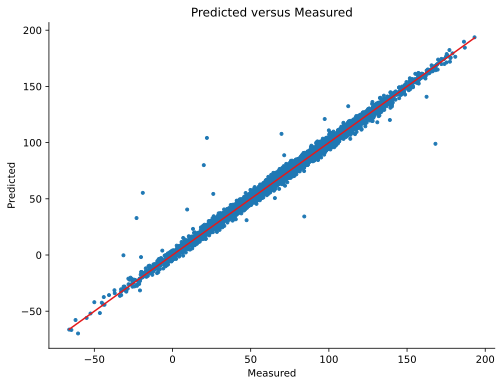

In [56]:
# Plot predicted versus measured
plot_scatter_line(
    y_all, predicted, label_predicted, label_measured, title,
    figure_width_height, graph_name
)

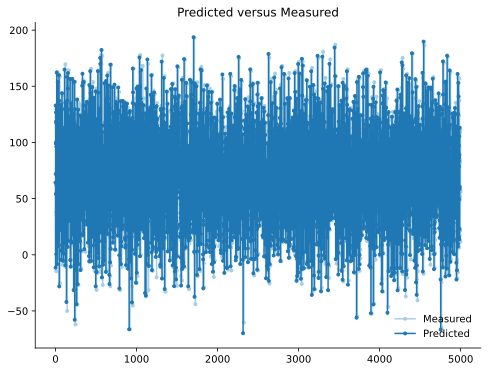

In [57]:
# Plot predicted versus measured
plot_line_line(y_all, predicted, label_measured, label_predicted, title,
               figure_width_height, graph_name)

In [58]:
end_time = datetime.now()
round((end_time - start_time).total_seconds(), 3)

1.886

# References

## numpy

- [API](https://numpy.org/devdocs/reference/index.html)

## pandas

- [API](https://pandas.pydata.org/docs/reference/index.html)

- [isna](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isna.html)

- [mask](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mask.html#pandas.DataFrame.mask)

- [options.display.max_rows, options.display.max_columns](https://pandas.pydata.org/docs/reference/api/pandas.set_option.html#pandas.set_option)

- [read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html#pandas.read_csv)

- [shape](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shape.html)

## python

- [library reference](https://docs.python.org/3/library/index.html)

- [datetime](https://docs.python.org/3/library/datetime.html)

## scikit-learn

- [API](https://scikit-learn.org/stable/modules/classes.html#)

- [compose module](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.compose)

- [compose.make_column_transformer function](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html#sklearn.compose.make_column_transformer)

- [ensemble module](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)

- [ensemble.RandomForestRegressor class](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)

- [feature_selection module](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)

- [feature_selection.SelectFromModel class](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel)

- [feature_selection.SelectFromModel.get_support() method](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel.get_support)

- [feature_selection.SelectKBest class](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest)

- [feature_selection.f_regression scoring function](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression)

- [impute module](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute)

- [impute SimpleImputer class](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer)

- [linear_model module](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)

- [linear_model.Lasso class](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)

- [linear_model.LassoCV class](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV)

- [linear_model.LinearRegression class](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

- [linear models User Guide](https://scikit-learn.org/stable/modules/linear_model.html#linear-model)

- [linear regression example](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

- [model_selection module](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)

- [model_selection cross_val_score function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score)

- [model_selection GridSearchCV class](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)

- [model_selection train_test_split function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split)

- [pipeline module](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline)

- [pipeline.make_pipeline function](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline)

- [tree module](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree)

- [tree.DecisionTreeRegressor class](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor)

## XGBoost

- [API](https://xgboost.readthedocs.io/en/latest/python/python_api.html)

- [XGBRegressor class](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

## statsmodels

- [API](https://www.statsmodels.org/stable/api.html)

## Machine learning

- [cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics))

- [feature selection](https://en.wikipedia.org/wiki/Feature_selection)

- [hyperparameter optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization)

- [imputation](https://en.wikipedia.org/wiki/Imputation_(statistics))

- [linear regression](https://en.wikipedia.org/wiki/Linear_regression)

# Glossary

**ColumnTransformer** It is a Class in scikit-learn that applies transformers to columns in a data set.

**Cross validation** It is a model validation technique for estimating how accurately a predictive model will perform in practice. In a prediction problem, a model is usually given a dataset of known data on which training is performed (training data set) and a data set of unknown data (or first-seen data) against which the model is tested (testing data set). Cross validation tests the model's ability to predict new data that was not used in estimating it in order to identify problems such as overfitting or selection bias, and to give insight on how the model will generalize to an independent (unknown) data set. One round of cross validation involves partitioning a sample of data into complementary subsets, performing the analyis on one subset (training set) and validating the analysis on the other subset (testing set). To reduce variability in the results, multiple rounds of cross validation are performed using different partitions and the validation results are combined (averaged) over the rounds to give an estimate of the model's predictive performance.

**Data leakage** It is inadvertently including knowledge from the testing data when training a model. The model will be less reliable. This may lead to incorrect decisions when tuning hyperparameters. This may lead to overestimating how well the model will perform on new data.

**Decision tree** It is a non-parametric supervised machine learning method used for classification and regression. It uses feature importance to determine potential features that could be in the model.

**Feature** It is an independent variable that is controlled in order to cause an outcome in the dependent variable.

**Feature selection** It is the process of selecting a set of features for a model. The data set probably contains features that are redundant or irrelevant, and can be removed with little effect on a model.

**Hyperparameter** It is a value you set during the model fitting process.

**Linear regression** It is a linear approach to modeling the relationship between a target and one or more features, using linear predictor functions where unknown model parameters are estimated from the data.

**Machine Learning** Machine learning algortihms build a mathematical model on a training data subset in order to make predictions on a test data subset. Various measures are used to compare the actual and predicted data in the test data subset to estimate the performance of the model.

**Mask** It is a pandas function that replaces a value with another value, a NaN by default.

**Parameter** It is a value learned during the model fitting process.

**Pipeline** A pipeline is a series of sequential steps. The output of each step is passed to the next step. It is a scikit-learn Class that applies one or more column transformations and a final estimator. The final estimator only needs to implement fit.The purpose is to assemble several steps that can be cross-validated together while setting different hyperparameters.

**Target** It is a dependent variable that represents the outcome resulting from altering features (independent variables).

**Testing data set** It is the data set upon which we use the model and put the values of the features to predict the target in order to compare the actual target values with the predicted values in order to evaluate the performance of the model.

**Training data set** It contains known values of the target. The model learns from these data, that is, we fit a model to estimate the relationship between the target and the features.

**Transformer** It is a scikit-learn object that transforms a column. For example, it can replace NaN with the average of all values in a column.

**Workflow** It is a repeatable pattern of activity, a sequence of operations. In scikit-learn, workflow is achieved through the Pipeline class.